In [1]:
from torch import nn,save,load
from torch.optim import Adam
from torch.utils.data import DataLoader 
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train  = datasets.MNIST(root="data",download=True,train=True,transform=ToTensor())

In [3]:
dataset = DataLoader(train,32)
#image shape (1,28,28)

In [4]:
import torch
from torch.autograd import Variable 
dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor #to run on gpu

N, D_in , H, D_out = 64, 1000,100,10
x = Variable(torch.randn(N,D_in).type(dtype), requires_grad=False)
y = Variable(torch.randn(N,D_out).type(dtype), requires_grad=False)

w1 = Variable(torch.randn(D_in,H).type(dtype), requires_grad=True)
w2 = Variable(torch.randn(H,D_out).type(dtype), requires_grad=True)

In [5]:
learning_rate = 1e-6
for t in range(500):
    y_pred = x.mm(w1).clamp(min=0).mm(w2)
    ##mm is matrix multiplication and clamp , clamps both all the values in the input range between a min and max values

    #calculate loss
    '''Now to compute the loss we are using the same popular loss function , sum of all squared difference of y_pred and y 
Loss is a variable of shape(1,) and loss.data is a Tensor of shape (1,) ; loss.data[0] is a scalar value holding loss'''
    loss = (y_pred - y).pow(2).sum()
    print(t, loss.data)
    '''Now we need to set the gradients of both sets of weights to 0 since graident buffers needs to be reset before fresh gradients are calculated'''

    '''now we will use autograd to compute the backward pass . this call will compute the gradient of loss wrt all variables with ```requires_grad=True``` 
after this w1.grad and w2.grad will be variables holding the grad of the loss wrt w1 and w2'''
    loss.backward()

    '''now we will update the weights using gradient descent . for this we will just mutate the values of w1 and w2 in place .'''
    w1.data -= learning_rate*w1.grad.data
    w2.data -= learning_rate*w2.grad.data
    w1.grad.data.zero_()
    w2.grad.data.zero_()

0 tensor(33270170., device='cuda:0')
1 tensor(27470686., device='cuda:0')
2 tensor(22492214., device='cuda:0')
3 tensor(16802672., device='cuda:0')
4 tensor(11348075., device='cuda:0')
5 tensor(7136090., device='cuda:0')
6 tensor(4403362.5000, device='cuda:0')
7 tensor(2792418., device='cuda:0')
8 tensor(1872906.5000, device='cuda:0')
9 tensor(1338226.5000, device='cuda:0')
10 tensor(1011292., device='cuda:0')
11 tensor(797833.5000, device='cuda:0')
12 tensor(648870.8750, device='cuda:0')
13 tensor(539041.1250, device='cuda:0')
14 tensor(454434.3750, device='cuda:0')
15 tensor(387117.5625, device='cuda:0')
16 tensor(332422.5000, device='cuda:0')
17 tensor(287260.6250, device='cuda:0')
18 tensor(249510.0312, device='cuda:0')
19 tensor(217725.2812, device='cuda:0')
20 tensor(190766.0781, device='cuda:0')
21 tensor(167798.8750, device='cuda:0')
22 tensor(148119.3438, device='cuda:0')
23 tensor(131202.6875, device='cuda:0')
24 tensor(116570.9531, device='cuda:0')
25 tensor(103857.2969, dev

This code initializes the weights and biases of a neural network layer using the Kaiming initialization method and uniform distribution.

The Kaiming initialization method is a type of weight initialization that is commonly used for deep neural networks.

It is designed to help prevent the "vanishing gradient" problem, which can occur when training deep neural networks with many layers.

The vanishing gradient problem occurs when the gradients of the weights in the network become very small, which can make it difficult for the network to learn and improve.

The Kaiming initialization method initializes the weights of a layer such that the variance of the outputs of that layer is equal to the variance of its inputs, which helps to ensure that the gradients of the weights do not vanish or explode during training.

The weights are initialized using a uniform distribution, which means that each weight is drawn from a uniform distribution over a specific range.

The code also initializes the biases of the layer using a uniform distribution. The bounds of the uniform distribution are calculated based on the number of input units in the layer (fan_in). This helps to ensure that the initial values of the biases are small and do not affect the outputs of the layer too much.

In [43]:
import math
from torch import nn
from torch import save,load
from torch.nn import functional as F
from torch.optim import Adam
#trying using MyReLU
class MyReLU(nn.Module):
    def forward(self, input):
        self.save_for_backward(input)
        return input.clamp(min=0)
    def backward(self, grad_output):
        input, = self.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input<0] = 0
        return grad_input
    def save_for_backward(self,x):
        self.saved_tensors = x
class MyConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.bias = bias
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels // groups, *kernel_size)) # one might want to cache some temporary state, like last hidden state of the RNN, in the model. 
                                                                                                    # If there was no such class as Parameter, these temporaries would get registered too.
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        #The Kaiming initialization method initializes the weights of a layer such that the variance of the outputs of that layer is equal to the variance of its inputs,
        # which helps to ensure that the gradients of the weights do not vanish or explode during training.
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None: # if there is some bias
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.conv2d(input, self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias) #when tried to use input + self.bias @ self.weight , val _acc is too low .. so it is a failure

In [44]:
class ImageClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            MyConv2d(1, 32, (3, 3)),
            MyReLU(),
            MyConv2d(32, 64, (3, 3)),
            MyReLU(),
            MyConv2d(64, 64, (3, 3)),
            MyReLU(),
            nn.Flatten(),
            MyLinear(64*(28-6)*(28-6), 10))
            
    def forward(self, x):
        return self.model(x)


In [45]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.optim import Adam
from tqdm import tqdm
#eval method from pytorch

train_loader = DataLoader(train, batch_size=64, shuffle=True)

def evaluate(model, data_loader, loss_fn):
    model.eval()  # Set the model to evaluation mode

    # Initialize the total loss and correct predictions
    total_loss = 0
    num_correct = 0

    # Loop over the validation data
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in data_loader:
            # Move the input and label tensors to the GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Update the total loss and number of correct predictions
            total_loss += loss.item() * inputs.size(0)
            num_correct += (outputs.argmax(dim=1) == labels).sum().item()

    # Compute the average loss and accuracy
    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = num_correct / len(data_loader.dataset)

    return avg_loss, accuracy


if __name__ == '__main__':
    model = ImageClassification().to('cuda')

    # Define the optimizer and loss function
    opt = Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    # Load the training and validation data
    train = MNIST(root='data', train=True, transform=ToTensor(), download=True)
    val_loader = DataLoader(MNIST(root='data', train=False, transform=ToTensor()), batch_size=64)
    # Loop over the number of epochs
    for epoch in range(5):
        # Loop over the training data
        for inputs, labels in tqdm(train_loader):
            # Move the input and label tensors to the GPU
            inputs, labels = inputs.to('cuda'), labels.to('cuda')

            # Zero out the gradients of the optimizer
            opt.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backward pass
            loss.backward()

            # Update the model weights
            opt.step()

        # Evaluate the model on the validation set
        val_loss, val_acc = evaluate(model, val_loader, loss_fn)

        # Print the epoch number, validation loss, and validation accuracy
        print(f'Epoch {epoch+1}: val_loss = {val_loss:.4f}, val_acc = {val_acc:.4f}')
    

100%|██████████| 938/938 [00:39<00:00, 24.02it/s]


Epoch 1: val_loss = 0.0478, val_acc = 0.9846


100%|██████████| 938/938 [00:09<00:00, 94.58it/s] 


Epoch 2: val_loss = 0.0407, val_acc = 0.9863


100%|██████████| 938/938 [00:08<00:00, 116.43it/s]


Epoch 3: val_loss = 0.0430, val_acc = 0.9860


100%|██████████| 938/938 [00:08<00:00, 116.99it/s]


Epoch 4: val_loss = 0.0397, val_acc = 0.9857


100%|██████████| 938/938 [00:07<00:00, 117.43it/s]


Epoch 5: val_loss = 0.0410, val_acc = 0.9879


In [46]:
# Save the model
torch.save(model.state_dict(), 'model.pt')


Predicted class: 2


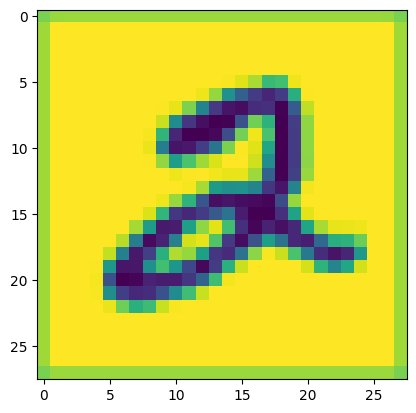

In [47]:
from PIL import Image
from torchvision.transforms import ToTensor
import torch
import matplotlib.pyplot as plt

# Preprocess the image
image = Image.open('/home/kalyan/gitrepo/AI-ML-Playground/PyTorch/MNIST/data/MNIST/download.png')  # Load the image
#chaning image channel to 1
image = image.convert('L')
image = image.resize((28, 28))  # Resize the image
image = ToTensor()(image)  # Convert the image to a tensor
image = image.unsqueeze(0)  # Add a batch dimension
image = image.to('cuda')  # Move the image to the GPU

# Forward pass
output = model(image)

# Get the predicted class
_, pred = output.max(dim=1)
pred = pred.item()

print(f'Predicted class: {pred}')
#plot image
plt.imshow(image.cpu().squeeze(0).permute(1, 2, 0))